# Testing of SAMueL-1 synthetic data: random forest model

In this notebook we test sthe ability of synthetic data to train a random forest model that is tested on real data. Data comes from 5 stratified k-vold traing/test sets. Synthetic data is generated from each k-fold training set. It is tested using the matching test set (which is not used in production of the synthetic data).

We use the double-SMOTE synthetic data (two rounds of SMOTE).

## Load packages

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

## Load data

In [2]:
data_loc = './../data/sam_1/kfold_5fold/'

train_data, test_data, synthetic_data = [], [], []

for i in range(5):
    train_data.append(pd.read_csv(f'{data_loc}train_{i}.csv'))
    test_data.append(pd.read_csv(f'{data_loc}test_{i}.csv'))
    #synthetic_data.append(pd.read_csv(f'{data_loc}synth_train_{i}.csv'))
    synthetic_data.append(pd.read_csv(f'{data_loc}synthetic_double_{i}.csv'))

## Build model and make predictions

For each of the k-fold sets, a model is built for each of real training data and synethetic data (generated based on that training set). The two models then predict probability of receiving thrombolysis for the matching k-fold test set.

In [3]:
# Set up lists for observed and predicted
observed_real = []
predicted_proba_real = []
predicted_real = []
observed_synthetic = []
predicted_proba_synthetic= []
predicted_synthetic = []
feature_importances_real = []
feature_importances_synthetic = []

# Loop through k folds
for k_fold in range(5):
        
    # Get k fold split
    train = train_data[k_fold]
    test = test_data[k_fold]
    synthetic = synthetic_data[k_fold]
    
    # Get X and y
    X_train = train.drop('S2Thrombolysis', axis=1)
    X_test = test.drop('S2Thrombolysis', axis=1)
    X_synthetic = synthetic.drop('S2Thrombolysis', axis=1)
    y_train = train['S2Thrombolysis']
    y_test = test['S2Thrombolysis']
    y_synthetic = synthetic['S2Thrombolysis']
    
    # One hot encode hospitals
    X_train_hosp = pd.get_dummies(X_train['StrokeTeam'], prefix = 'team')
    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    X_train.drop('StrokeTeam', axis=1, inplace=True)
    X_test_hosp = pd.get_dummies(X_test['StrokeTeam'], prefix = 'team')
    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    X_test.drop('StrokeTeam', axis=1, inplace=True)
    X_synthetic_hosp = pd.get_dummies(X_synthetic['StrokeTeam'], prefix = 'team')
    X_synthetic = pd.concat([X_synthetic, X_synthetic_hosp], axis=1)
    X_synthetic.drop('StrokeTeam', axis=1, inplace=True)
        
    # Train and test using real data
    
    # Define model
    model = RandomForestClassifier(
        n_estimators=100, n_jobs=-1, class_weight='balanced', random_state=42)
    
    # Fit model
    model.fit(X_train, y_train)
    
    # Get predicted probabilities
    y_probs_real = model.predict_proba(X_test)[:,1]
    observed_real.append(y_test)
    predicted_proba_real.append(y_probs_real)
    predicted_real.append(y_probs_real >= 0.5)
    
    # Get feature importances
    importance = model.feature_importances_
    feature_importances_real.append(importance)
    
    # Train and test using synthetic data
    
    # Define model
    model = RandomForestClassifier(
        n_estimators=100, n_jobs=-1, class_weight='balanced', random_state=42)
    
    # Fit model
    model.fit(X_synthetic, y_synthetic)
    
    # Get predicted probabilities
    y_probs_synthetic = model.predict_proba(X_test)[:,1]
    observed_synthetic.append(y_test)
    predicted_proba_synthetic.append(y_probs_synthetic)
    predicted_synthetic.append(y_probs_synthetic >= 0.5)
    
    # Get feature importances
    importance = model.feature_importances_
    feature_importances_synthetic.append(importance)

## Test accuracy

In [4]:
accuracy_real = []
accuracy_synthetic = []
for k_fold in range(5):
    correct = predicted_real[k_fold] == test_data[k_fold]['S2Thrombolysis']
    accuracy_real.append(correct.mean())
    correct = predicted_synthetic[k_fold] == test_data[k_fold]['S2Thrombolysis']
    accuracy_synthetic.append(correct.mean())

real_mean = np.mean(accuracy_real)
real_sem = np.std(accuracy_real)/(np.sqrt(5))
synthetic_mean = np.mean(accuracy_synthetic)
synthetic_sem = np.std(accuracy_synthetic)/(np.sqrt(5))

results = pd.DataFrame()
results['real'] = accuracy_real
results['synthetic'] = accuracy_synthetic
print ('Individual kfold results:')
print (results.round(3))
print ()        

print ('Accuracy when model trained using real data:')
print (f'Mean = {real_mean:0.3f}, SEM = {real_sem:0.3f}')
print ()
print ('Accuracy when model trained using synthetic data')
print (f'Mean = {synthetic_mean:0.3f}, SEM = {synthetic_sem:0.3f}')

Individual kfold results:
    real  synthetic
0  0.845      0.836
1  0.846      0.838
2  0.843      0.832
3  0.850      0.839
4  0.844      0.836

Accuracy when model trained using real data:
Mean = 0.846, SEM = 0.001

Accuracy when model trained using synthetic data
Mean = 0.836, SEM = 0.001


## Compare feature importances

Compare mean feature importances across 5 k-fold model fits.

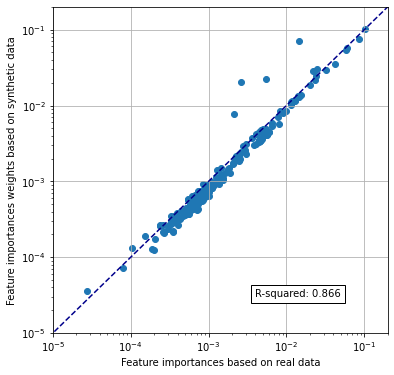

In [5]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
x = abs(np.mean(feature_importances_real, axis=0))
y = abs(np.mean(feature_importances_synthetic, axis=0))
ax1.scatter(x,y)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e-5, 2e-1)
ax1.set_ylim(1e-5, 2e-1)
ax1.plot([0, 100], [0, 100], color='darkblue', linestyle='--')
ax1.grid()
rsquare = np.corrcoef(x, y) ** 2 
rsquare = rsquare[0,1]
text = f'R-squared: {rsquare:0.3f}'
ax1.text(4e-3, 3e-5,text, bbox=dict(facecolor='white', edgecolor='black'))
ax1.set_xlabel('Feature importances based on real data')
ax1.set_ylabel('Feature importances weights based on synthetic data')
plt.show()

## Receiver operator characteristic curve

In [6]:
fpr_real = []
tpr_real = []
auc_real = []
fpr_synthetic = []
tpr_synthetic = []
auc_synthetic = []

for k_fold in range(5):
    y_test = test_data[k_fold]['S2Thrombolysis']
    # real ROC
    fpr, tpr, thresholds = roc_curve(y_test, predicted_proba_real[k_fold])
    fpr_real.append(fpr)
    tpr_real.append(tpr)
    auc_real.append(auc(fpr, tpr))
    
    # Synthetic ROC
    fpr, tpr, thresholds = roc_curve(y_test, predicted_proba_synthetic[k_fold])
    fpr_synthetic.append(fpr)
    tpr_synthetic.append(tpr)
    auc_synthetic.append(auc(fpr, tpr))
    
auc_real_mean = np.mean(auc_real)
auc_synthetic_mean = np.mean(auc_synthetic)
auc_real_sem = np.std(auc_real)/(np.sqrt(5))
auc_synthetic_sem = np.std(auc_synthetic)/(np.sqrt(5))

print ('ROC AUC when model trained using real data:')
print (f'Mean = {auc_real_mean:0.3f}, SEM = {auc_real_sem:0.3f}')
print ()
print ('ROC AUC when model trained using synthetic data')
print (f'Mean = {auc_synthetic_mean:0.3f}, SEM = {auc_synthetic_sem:0.3f}')

ROC AUC when model trained using real data:
Mean = 0.914, SEM = 0.001

ROC AUC when model trained using synthetic data
Mean = 0.907, SEM = 0.001


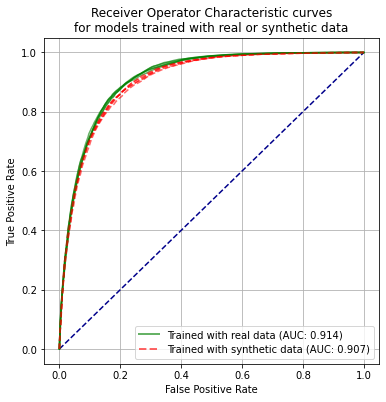

In [7]:
fig = plt.figure(figsize=(6,6))

# Plot ROC
ax1 = fig.add_subplot()
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic curves\nfor models trained with real or synthetic data')

for k in range(5):
    ax1.plot(fpr_real[k],tpr_real[k], color='green', alpha=0.6, 
             label = 'Real training data')
    ax1.plot(fpr_synthetic[k],tpr_synthetic[k], color='red', alpha=0.6,
             linestyle='--', label = 'Synthetic training data')


custom_lines = [Line2D([0], [0], color='green', alpha=0.6, lw=2),
                Line2D([0], [0], color='red', linestyle='--', alpha = 0.6,lw=2)]

plt.legend(custom_lines, 
           [f'Trained with real data (AUC: {auc_real_mean:.3f})',
           f'Trained with synthetic data (AUC: {auc_synthetic_mean:.3f})'],
          loc='lower right')

plt.grid(True)

plt.savefig('images/synthetic_roc_random_forest.png')
plt.show()